In [1]:
import numpy as np # NumPy for numerical operations
import matplotlib.pyplot as plt # Matplotlib for plotting
import cv2 # OpenCV for image processing

## Correção Gamma

In [2]:
def gamma_transform(img, gamma):
    c = 255.0 / 255.0**gamma
    img_gamma = c * (img.astype(np.float32))**gamma
    return img_gamma.astype(np.uint8)

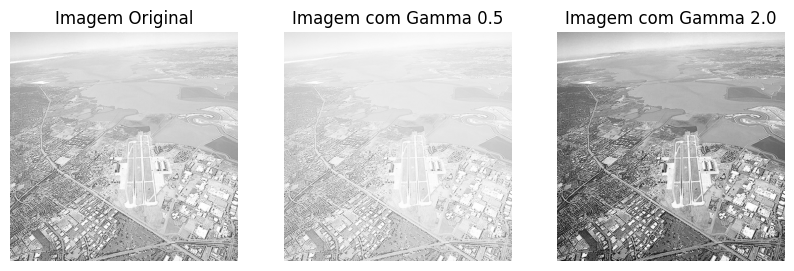

In [3]:
img = plt.imread('images/cidade_branca.jpg')

img_gamma = gamma_transform(img, 0.5)
img_gamma2 = gamma_transform(img, 2.0)
fig, axes = plt.subplots(1,3, figsize=(10,5))
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title('Imagem Original')
axes[0].imshow(img)
axes[1].set_title('Imagem com Gamma 0.5')
axes[1].imshow(img_gamma)
axes[2].set_title('Imagem com Gamma 2.0')
axes[2].imshow(img_gamma2)
plt.show()

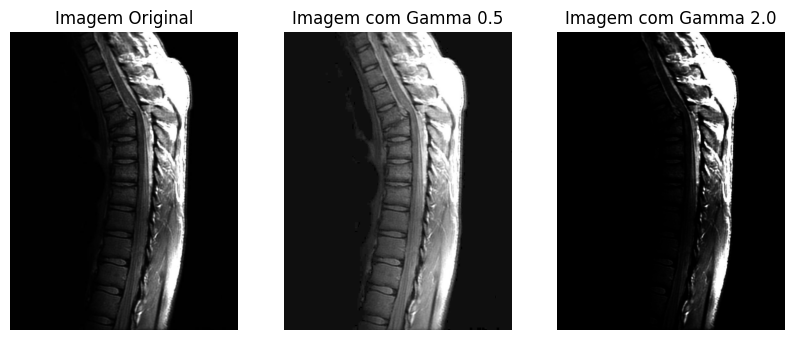

In [4]:
img = plt.imread('images/osso_fraturado.jpg')

img_gamma = gamma_transform(img, 0.5)
img_gamma2 = gamma_transform(img, 2.0)
fig, axes = plt.subplots(1,3, figsize=(10,5))
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title('Imagem Original')
axes[0].imshow(img)
axes[1].set_title('Imagem com Gamma 0.5')
axes[1].imshow(img_gamma)
axes[2].set_title('Imagem com Gamma 2.0')
axes[2].imshow(img_gamma2)
plt.show()

## Transformação Linear Definida por Partes

In [5]:
def transformacao_linear_por_partes(img):
    img = img.astype(np.float32)
    r_min = np.min(img)
    r_max = np.max(img)
    diff = r_max - r_min
    img_out = ((255/diff) * img) - (255*r_min/diff)
    return img_out.astype(np.uint8)

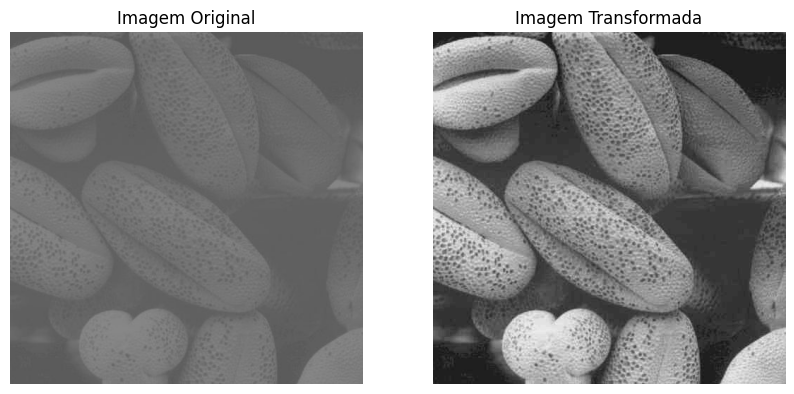

In [6]:
img = plt.imread('images/negocio_estranho.jpg')

img_out = transformacao_linear_por_partes(img)
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title('Imagem Original')
axes[0].imshow(img)
axes[1].set_title('Imagem Transformada')
axes[1].imshow(img_out)
plt.show()

## Limiarização

In [7]:
def limiariza(img, th):
    img_th = np.zeros(img.shape, dtype=np.uint8)
    img_th[img > th] = 255
    return img_th

In [8]:
def limiariza2(img,a, b):
    img_th = np.zeros(img.shape, dtype=np.uint8)
    img_th[(img > a) & (img < b)] = 255
    return img_th

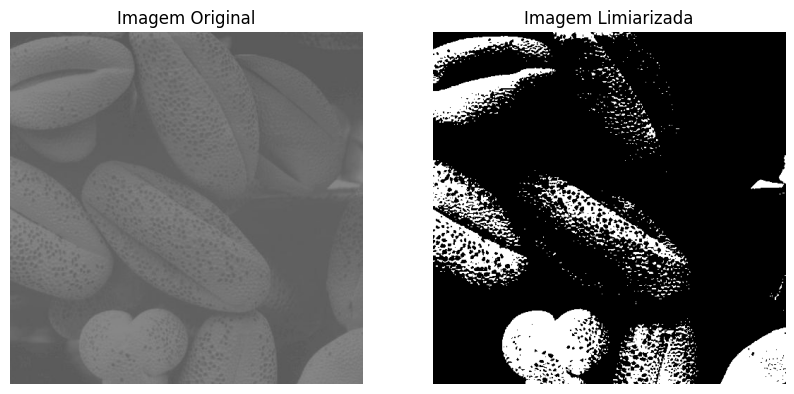

In [9]:
img = plt.imread('images/negocio_estranho.jpg')

# img_limiarizada = limiariza(img, 120)
img_limiarizada = limiariza2(img, 120, 180)
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title('Imagem Original')
axes[0].imshow(img)
axes[1].set_title('Imagem Limiarizada')
axes[1].imshow(img_limiarizada)
plt.show()

## Equalização de Histogramas

In [12]:
def equal_histo(img):
    altura, largura = img.shape  
    total_pixels = altura * largura
    
    histograma = [0] * 256
    for i in range(altura):
        for j in range(largura):
            pixel_value = img[i, j]
            histograma[pixel_value] += 1
    
    probabilidades = [freq / total_pixels for freq in histograma]
    
    cdf = [0] * 256
    cdf[0] = probabilidades[0]
    for i in range(1, 256):
        cdf[i] = cdf[i-1] + probabilidades[i]
    
    mapeamento = [int(round(255 * cdf_val)) for cdf_val in cdf]
    
    img_out = img.copy()
    for i in range(altura):
        for j in range(largura):
            pixel_original = img[i, j]
            img_out[i, j] = mapeamento[pixel_original]
    
    return img_out



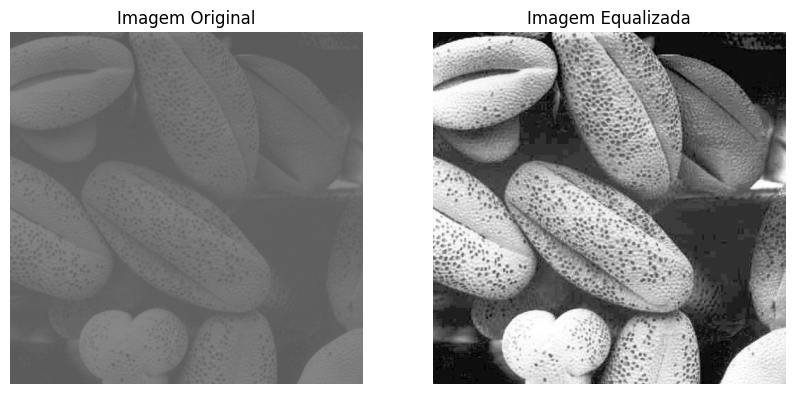

In [13]:
img = cv2.imread('images/negocio_estranho.jpg', cv2.IMREAD_GRAYSCALE)

img_eq = equal_histo(img)
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title('Imagem Original')
axes[0].imshow(img, cmap='gray', vmin=0, vmax=255)
axes[1].set_title('Imagem Equalizada')
axes[1].imshow(img_eq, cmap='gray', vmin=0, vmax=255)
plt.show()




## Especificação do histograma

In [23]:
def histogram_matching_like_image(img_input, img_ref):
    # 1. Inicializa arrays para armazenar histogramas e CDFs
    # Corresponde a 'pr', 'pz', 'cdf_input', 'cdf_ref' das imagens
    hist_input = np.zeros((256, 3))
    hist_ref = np.zeros((256, 3))
    
    cdf_input = np.zeros((256, 3))
    cdf_ref = np.zeros((256, 3))

    # 2. Separa os canais de cor e calcula o histograma para cada um
    # Corresponde aos loops de 'cv2.calcHist'
    for i in range(3):
        # Calcula o histograma para o canal 'i' da imagem de entrada
        hist_input[:, i] = cv2.calcHist([img_input], [i], None, [256], [0, 256]).ravel()
        # Calcula o histograma para o canal 'i' da imagem de referência
        hist_ref[:, i] = cv2.calcHist([img_ref], [i], None, [256], [0, 256]).ravel()

        # Normaliza os histogramas (passo implícito, mas necessário)
        hist_input[:, i] /= hist_input[:, i].sum()
        hist_ref[:, i] /= hist_ref[:, i].sum()

        # 3. Calcula as Funções de Distribuição Cumulativa (CDFs)
        # Corresponde ao loop de 'np.cumsum'
        cdf_input[:, i] = np.cumsum(hist_input[:, i])
        cdf_ref[:, i] = np.cumsum(hist_ref[:, i])

    # 4. Cria a imagem de saída e a tabela de mapeamento (LUT)
    img_out = np.zeros_like(img_input)
    mapping_lut = np.zeros((256, 3), dtype=np.uint8)

    # 5. Encontra o mapeamento de intensidade para cada canal
    # Este loop implementa a lógica principal de correspondência vista na imagem
    # 'diff = np.absolute(cdf_ref[:,c] - cdf_input[i,c])' e 'indice = diff.argmin()'
    for c in range(3): # Itera sobre os canais de cor (B, G, R)
        for i in range(256): # Itera sobre os níveis de intensidade
            # Encontra o nível de intensidade 'j' na CDF de referência que é o mais próximo
            # do valor da CDF de entrada no nível de intensidade 'i'
            diff = np.abs(cdf_input[i, c] - cdf_ref[:, c])
            j = np.argmin(diff)
            mapping_lut[i, c] = j
            
        # Aplica o mapeamento para o canal inteiro de uma vez (mais eficiente)
        # A lógica na imagem ('img_out[img_input[:,:,c] == i, c] = indice') é muito lenta.
        # Esta abordagem com LUT produz o mesmo resultado de forma otimizada.
        img_out[:, :, c] = mapping_lut[img_input[:, :, c], c]

    return img_out

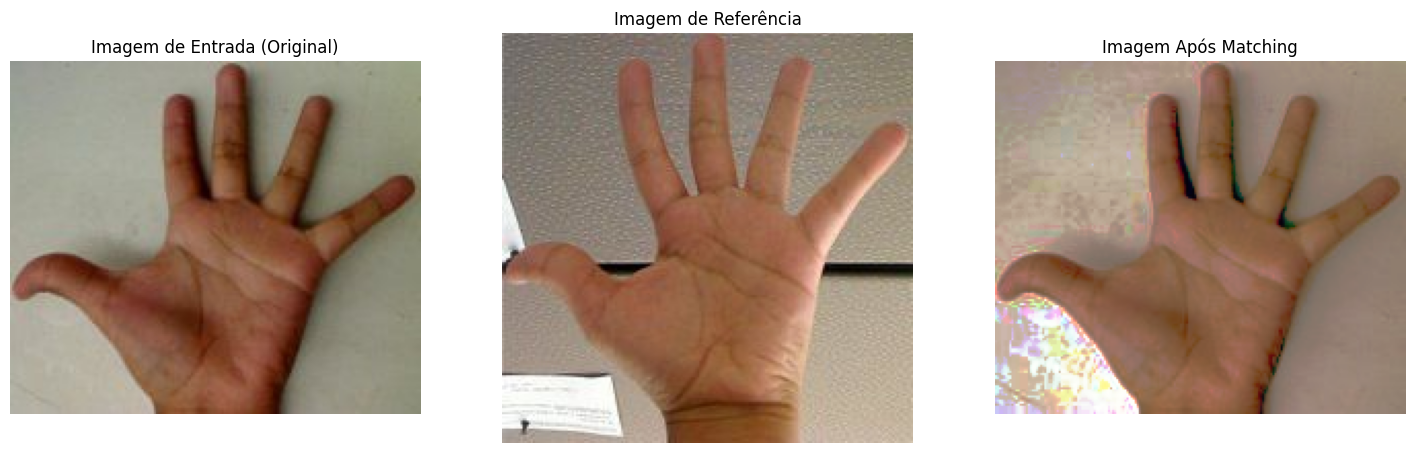

In [24]:
m1 = cv2.imread('images/m1.jpeg')
m2 = cv2.imread('images/m2.jpeg')


if m1 is None or m2 is None:
    raise FileNotFoundError("Verifique se 'histogram_matching_input.jpeg' e 'histogram_matching_ref1.jpeg' estão no diretório correto.")

matched_image = histogram_matching_like_image(m1, m2)

m1_rgb = cv2.cvtColor(m1, cv2.COLOR_BGR2RGB)
m2_rgb = cv2.cvtColor(m2, cv2.COLOR_BGR2RGB)
matched_rgb = cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(m1_rgb)
axes[0].set_title('Imagem de Entrada (Original)')
axes[0].axis('off')
axes[1].imshow(m2_rgb)
axes[1].set_title('Imagem de Referência')
axes[1].axis('off')
axes[2].imshow(matched_rgb)
axes[2].set_title('Imagem Após Matching')
axes[2].axis('off')

plt.show()

## manipulação de imagem 

In [ ]:
def resizeImg(img, sch, scw):
    '''
      img: imagem de entrada
      sch: fator de escala na altura
      scw: fator de escala na largura
    '''
    h, w, c = img.shape # dimensoes de img (linhas, colunas, canais)

    # aloca a nova imagem
    nh = int(round(h * sch))
    nw = int(round(w * scw))
    newImg = np.zeros((nh, nw, c), dtype=np.uint8)

    # indices dos pixels da nova imagem
    Ro = np.arange(nh)
    Co = np.arange(nw)

    # calcula os fatores de escala
    Sr = float(h) / float(nh) # h = numero de linhas da imagem original; nh= nova
    Sc = float(w) / float(nw) # w = numero de colunas da imagem original; nw = nova

    #calcula o mapeamento dos indices
    Rm = Ro * Sr
    Cm = Co * Sc

    R = np.round(Rm).astype(int)
    C = np.round(Cm).astype(int)

    coord_new = [(x,y) for x in Ro for y in Co] # coodenadas de pixel da imagem nova
    coord_ori = [(x,y) for x in R for y in C] # coordendas novas mapeadas
    for cn, co in zip(coord_new, coord_ori):
        newImg[cn] = img[co]

    return newImg